In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

In [2]:
df = pd.read_excel("Case Prediction Data2.xlsx")

In [3]:
df_comp = df[df["Product"] == "Partnership / S Corp / Pass-Through"]
df_comp.head()

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title
140,205296,CA form 568 sch B not calculating correctly,2017-01-04 12:19:00,2017-01-04 17:08:00,Web,High,Tax Preparation,Question / How To,Silver,"Is there a way to populate CA Form 568, Schedu...",Partnership / S Corp / Pass-Through,Returns / Reports,NaN,NaN,US.CA,Answer exists KB,041231308551644,CA Return - An amount entered to account 8CA31...
189,205377,Stockholder Ownership Percentages,2017-01-04 16:53:00,2017-01-05 10:48:00,Web,High,Tax Preparation,Problem / Error,Silver,The stockholder ownership percentages are not ...,Partnership / S Corp / Pass-Through,K1 Data,NaN,NaN,US,Provide solution - no KB required (e.g. client...,NaN,NaN
273,205521,IT-65 Data Entry Addbacks,2017-01-05 14:02:00,2017-01-05 15:24:00,Web,High,Tax Preparation,Question / How To,Silver,"Hello, I am having trouble locating the area ...",Partnership / S Corp / Pass-Through,Returns / Reports,NaN,NaN,US.IN,Create/Update KB,NaN,NaN
351,205672,Will the date for partnership return change on...,2017-01-06 13:13:00,2017-01-06 16:59:00,Phone,Medium,Tax Preparation,Question / How To,Silver,Will the date for partnership return change on...,Partnership / S Corp / Pass-Through,Returns / Reports,NaN,NaN,NaN,Answer exists KB,NaN,NaN
377,205714,Importing Footnotes with References,2017-01-06 14:55:00,2017-01-09 14:23:00,Web,Medium,Tax Preparation,Question / How To,Gold,Excel File with the Data Dictionary references...,Partnership / S Corp / Pass-Through,Setup,NaN,NaN,NaN,Answer exists KB,NaN,NaN


In [4]:
#dfc = df[df.Product == "Compliance"]
df_comp['Date Created'] = df_comp['Date Created'].dt.date
df_comp['Date Closed'] = df_comp['Date Closed'].dt.date
df_comp['Date'] = pd.to_datetime(df_comp['Date Created'], errors='coerce')
dfc = df_comp

In [5]:
# Adding a new column which will have the number of tickets per day
newdf = dfc[["Date","Case Number"]]
newdf.drop_duplicates(inplace=True)
newdf['Date'] = pd.to_datetime(newdf['Date'])
newdf = pd.DataFrame(newdf.groupby([newdf["Date"].dt.date]).count()["Case Number"])
newdf = newdf.reset_index()
newdf.index = newdf.Date
newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
newdf = newdf.asfreq('D')
newdf = newdf.groupby(pd.Grouper(freq="M")).sum()
newdf

,Case Number
Date,
2017-01-31,42.0
2017-02-28,97.0
2017-03-31,161.0
2017-04-30,93.0
2017-05-31,153.0
...,...
2022-04-30,118.0
2022-05-31,162.0
2022-06-30,185.0


In [6]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2017-01-31 to 2022-08-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Case Number  68 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [8]:
f = Forecaster(y=newdf['Case Number'],current_dates=newdf.index)
f

Forecaster(
    DateStartActuals=2017-01-31T00:00:00.000000000
    DateEndActuals=2022-08-31T00:00:00.000000000
    Freq=M
    N_actuals=68
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [9]:
f = Forecaster(y=newdf['Case Number'],current_dates=newdf.index)
f.generate_future_dates(12)
f.set_test_length(.2)
f.set_estimator('arima')
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -1.26
the p-value is 0.6494
the series is not stationary
----------------------------------------------------------------------------------------------------


In [10]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=10,
    max_q=10,
    m=12,
    seasonal=True,
    max_P=10, 
    max_D=10,
    max_Q=10,
    max_d=10,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='auto_arima',
)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=452.153, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=447.991, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=446.965, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=450.411, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=451.214, Time=0.04 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=448.680, Time=0.09 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=447.179, Time=0.04 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=447.602, Time=0.11 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=447.723, Time=0.13 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=446.330, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=449.84

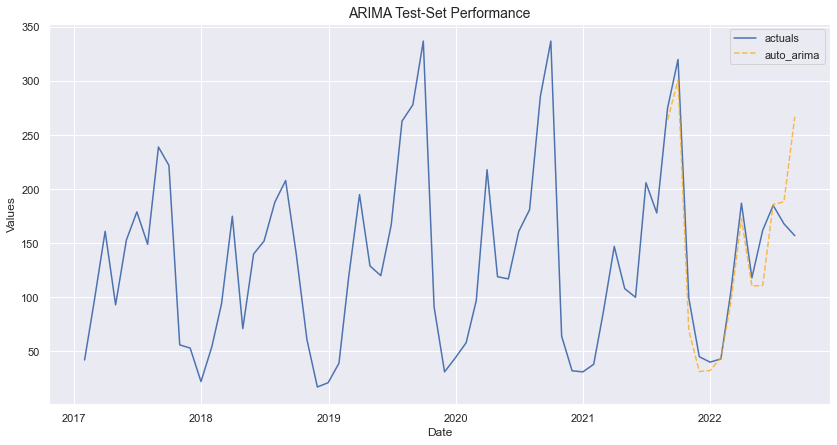

In [11]:
f.plot_test_set(ci=False,models='auto_arima')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

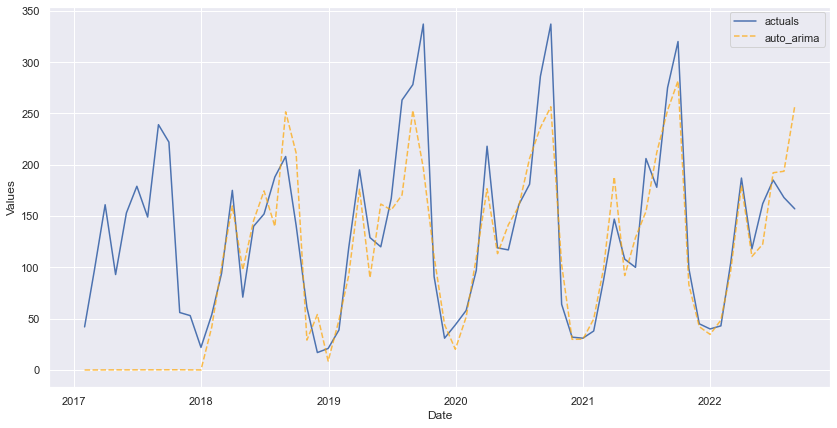

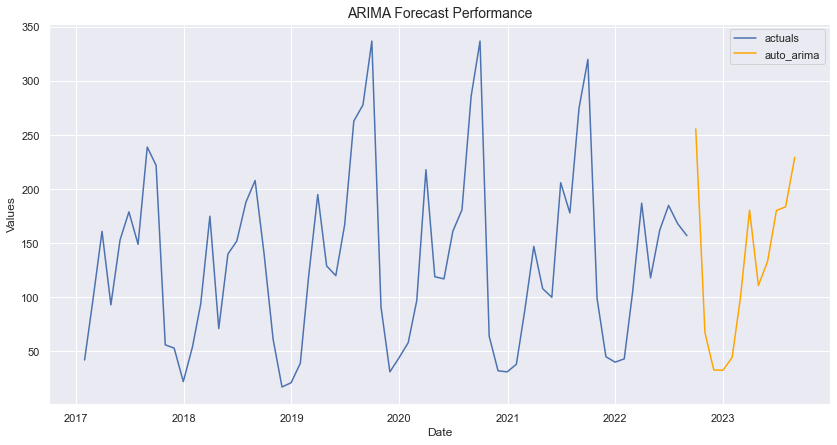

In [12]:
f.plot_fitted()
f.plot(ci=False,models='auto_arima')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [13]:
result_train = f.export_fitted_vals(model = "auto_arima")
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(result_train["Actuals"], result_train["FittedVals"]))
rms

68.48621082448086

In [14]:
pd.options.display.max_colwidth = 100
# results = f.export(to_excel=True,
#                    excel_name='arima_results.xlsx',
#                    determine_best_by='TestSetMAPE')
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx')
pd.set_option('display.max_columns', None)
results["model_summaries"]

,ModelNickname,Estimator,Xvars,HyperParams,Scaler,Observations,Tuned,CrossValidated,DynamicallyTested,Integration,TestSetLength,TestSetRMSE,TestSetMAPE,TestSetMAE,TestSetR2,LastTestSetPrediction,LastTestSetActual,CILevel,CIPlusMinus,InSampleRMSE,InSampleMAPE,InSampleMAE,InSampleR2,ValidationSetLength,ValidationMetric,ValidationMetricValue,models,weights,LevelTestSetRMSE,LevelTestSetMAPE,LevelTestSetMAE,LevelTestSetR2,LevelInSampleRMSE,LevelInSampleMAPE,LevelInSampleMAE,LevelInSampleR2,best_model
0,auto_arima,arima,None,"{'order': (1, 0, 0), 'seasonal_order': (0, 1, 1, 12), 'trend': None}",None,68,False,False,True,0,13,36.234731,0.177136,22.793365,0.805557,266.895386,157.0,0.95,84.099379,68.486211,0.38212,44.506509,0.282703,None,None,None,None,None,36.234731,0.177136,22.793365,0.805557,68.486211,0.38212,44.506509,0.282703,True


In [16]:
print("mean",newdf.mean()[0])
print("max",newdf.max()[0])
print("min",newdf.min()[0])
print("std",newdf.std()[0])
print("lvl_fcsts",results["lvl_fcsts"])

mean 133.36764705882354
max 337.0
min 17.0
std 81.46492779136724
lvl_fcsts          DATE  auto_arima
0  2022-09-30  255.787066
1  2022-10-31   67.431191
2  2022-11-30   32.753387
3  2022-12-31   32.460840
4  2023-01-31   44.293391
5  2023-02-28   99.166240
6  2023-03-31  180.603494
7  2023-04-30  110.898872
8  2023-05-31  133.152627
9  2023-06-30  180.338421
10 2023-07-31  183.681259
11 2023-08-31  229.459001
